# 추세투자법

| 항목  |      설명      |
|------|:----------- -:|
| 스타일 |  자산배분 + 모멘텀 |
| 기대 CAGR | 코스피 + 2 ~ 3%   |
| 매수 전략 | 3개월 이동평균이 상승반전하면 코스피 지수 매수|
| 매도 전략 | 3개월 이동평균이 하락반전하면 코스피 지수 매도한 후 전액 현금 보유|

In [1]:
%load_ext autoreload
%autoreload 2

## Data preparation

In [2]:
from lib.utils.data_utils import load_data

kospi_df = load_data('^KS11')

/Users/s_park/opt/anaconda3/envs/backtrader/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Run back-test.

In [3]:
import logging

import backtrader as bt

from lib.utils.logging import configure_logger
from lib.strategies.sma_momentum_strategy import SMAMomentumStrategy
configure_logger()

# Create a backtest runtime.
cerebro = bt.Cerebro()
cerebro.addstrategy(SMAMomentumStrategy, maperiod=60, buy_margin=0.03, rocperiod=7)
initial_cash = 10000000
cerebro.broker.setcash(initial_cash)
cerebro.broker.setcommission(commission=0.00165)

# Feed Data.
kospi_data = bt.feeds.PandasData(dataname=kospi_df)
cerebro.adddata(kospi_data, name='KOSPI')

# Data analyzers.
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='draw_down')
cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='positions_value', cash=True, headers=True)

# Run it!
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
res = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000000.00
Final Portfolio Value: 61742648.46


## Visualize your strategy

<IPython.core.display.Javascript object>


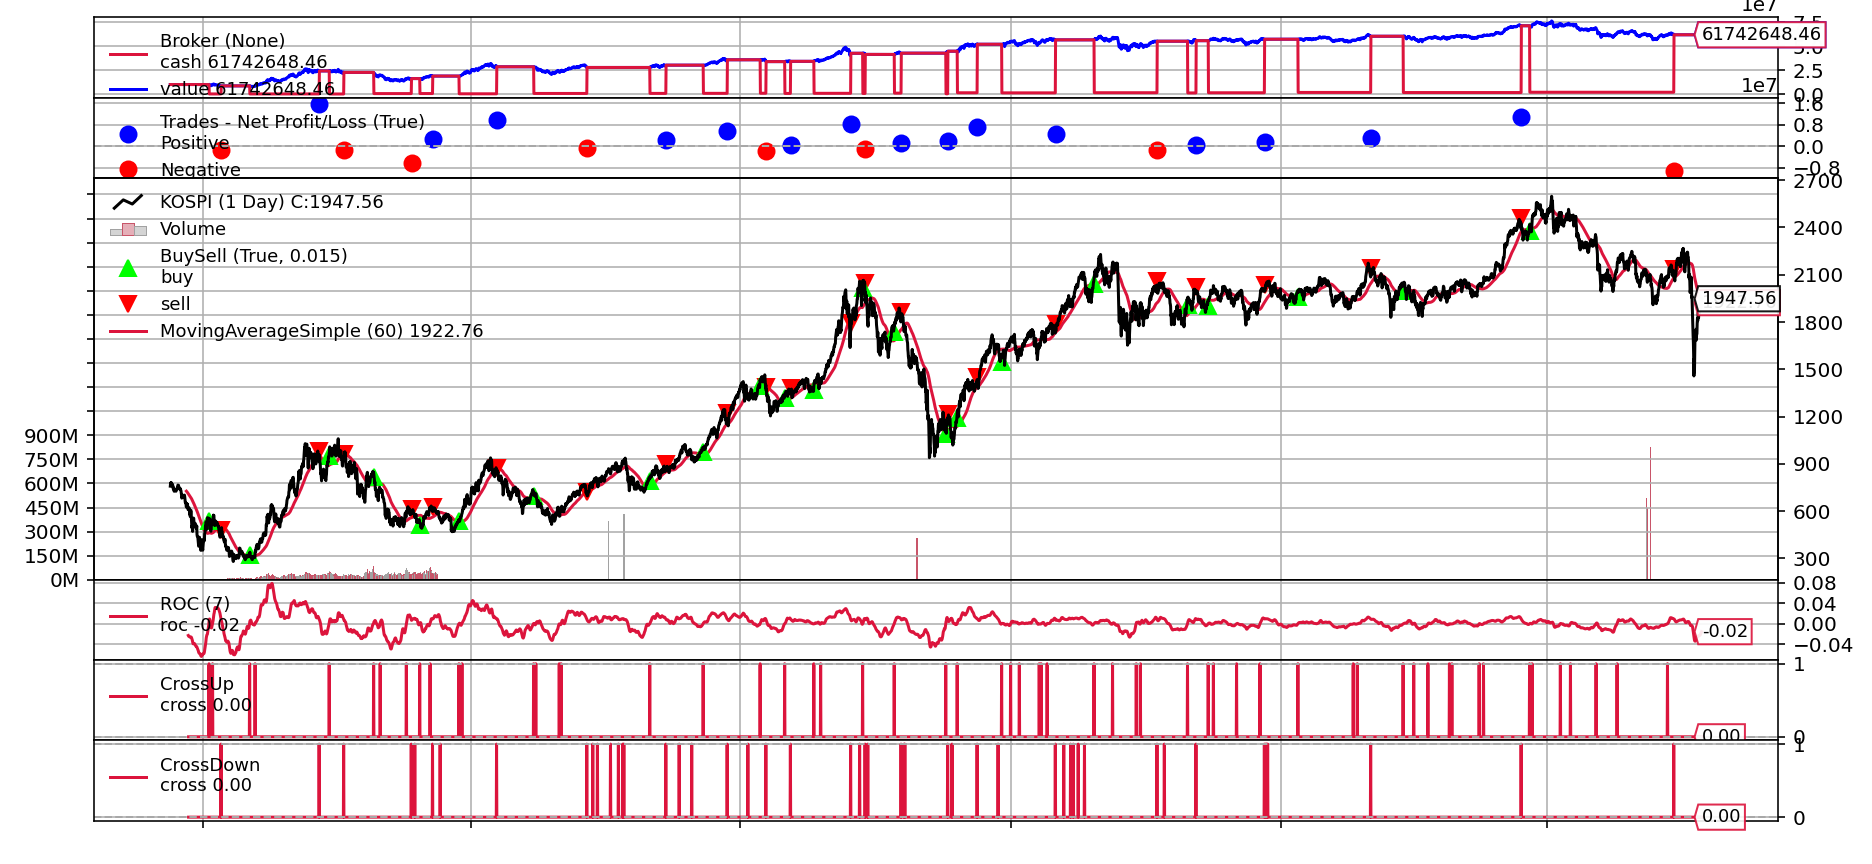

[[<Figure size 936x432 with 7 Axes>]]

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,6)
cerebro.plot()

or 
## Analyze the performance by yourself.

In [10]:
%matplotlib inline
import empyrical as ep
import pandas as pd

from lib.utils.analyzer_utils import annual_return_to_df, positions_value_to_df

sma_return_df = annual_return_to_df(res[0].analyzers.annual_return.get_analysis())
sma_positions_value_df = positions_value_to_df(res[0].analyzers.positions_value.get_analysis(), enrich_total=True, total_col_name='total')
sharpe_ratio = res[0].analyzers.sharpe.get_analysis()['sharperatio']
mdd = res[0].analyzers.draw_down.get_analysis()["max"]["drawdown"]
cagr = ep.cagr(sma_positions_value_df['total'].pct_change(), period="daily", annualization=None)
 
sma_report_df = pd.DataFrame(
    dict(
        initial_value = initial_cash,
        final_value = cerebro.broker.get_value(),
        period_start = sma_positions_value_df.index.min(),
        period_end = sma_positions_value_df.index.max(),
        sharpe_ratio = sharpe_ratio,
        mdd = mdd,
        cagr = cagr
    ),
    index=['SmaMomentum']
)

pd.set_option('float_format', '{:.3f}'.format)
sma_report_df

,initial_value,final_value,period_start,period_end,sharpe_ratio,mdd,cagr
SmaMomentum,10000000,25448810.483,1997-07-01,2020-04-29,0.385,48.404,0.085


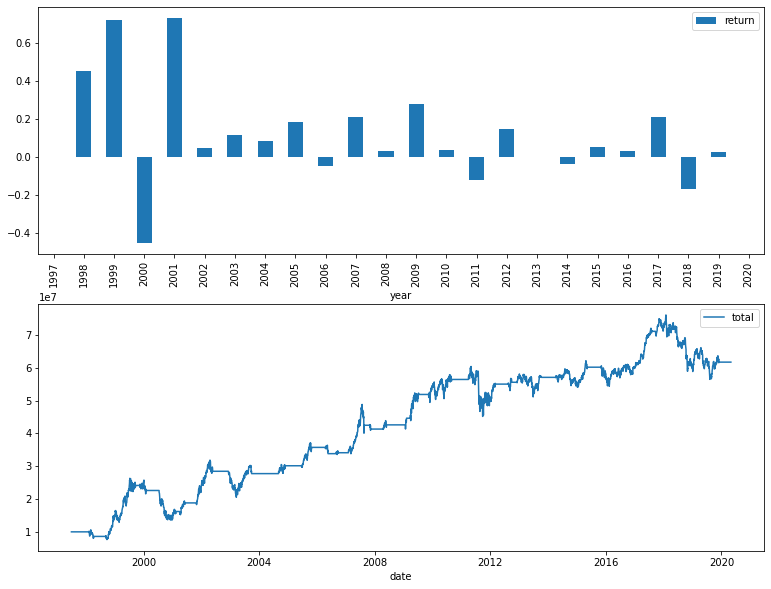

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,10)
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)


sma_return_df.plot.bar(ax=ax1)
sma_positions_value_df[['total']].plot(ax=ax2)

# Benchmark test

In [7]:
# Scenario 1
from lib.strategies.hold_all_strategy import HoldAllStrategy

cerebro = bt.Cerebro()
cerebro.addstrategy(HoldAllStrategy, buy_date='1997-01-01')
cerebro.broker.setcash(initial_cash)
cerebro.broker.setcommission(commission=0.00165)

# Feed Data.
kospi_data = bt.feeds.PandasData(dataname=kospi_df)
cerebro.adddata(kospi_data, name='KOSPI')


# Data analyzers.
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='draw_down')
cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='positions_value', cash=True, headers=True)

# Run it!
kospi_res = cerebro.run()
kospi_annual_return_df = annual_return_to_df(kospi_res[0].analyzers.annual_return.get_analysis())
kospi_positions_value_df = positions_value_to_df(kospi_res[0].analyzers.positions_value.get_analysis(), enrich_total=True, total_col_name='total')
sharpe_ratio = kospi_res[0].analyzers.sharpe.get_analysis()['sharperatio']
mdd = kospi_res[0].analyzers.draw_down.get_analysis()["max"]["drawdown"]
cagr = ep.cagr(kospi_positions_value_df['total'].pct_change(), period="daily", annualization=None)

kospi_report_df = pd.DataFrame(
    dict(
        initial_value = initial_cash,
        final_value = cerebro.broker.get_value(),
        period_start = kospi_positions_value_df.index.min(),
        period_end = kospi_positions_value_df.index.max(),
        sharpe_ratio = sharpe_ratio,
        mdd = mdd,
        cagr = cagr
    ),
    index=['HoldStrategy_KOSPI']
)

pd.set_option('float_format', '{:.3f}'.format)

In [11]:
import pandas as pd
overall_report_df = pd.concat([sma_report_df, kospi_report_df])
overall_report_df

,initial_value,final_value,period_start,period_end,sharpe_ratio,mdd,cagr
SmaMomentum,10000000,25448810.483,1997-07-01,2020-04-29,0.385,48.404,0.085
HoldStrategy_KOSPI,10000000,25448810.483,1997-07-01,2020-04-29,0.255,64.095,0.043


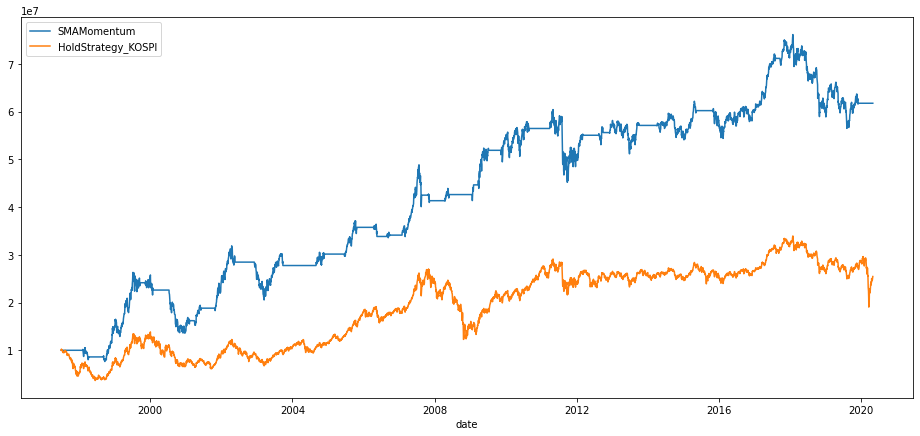

In [9]:
df = pd.DataFrame()
df['SMAMomentum'] = sma_positions_value_df['total']
df['HoldStrategy_KOSPI'] = kospi_positions_value_df['total']
plt.rcParams["figure.figsize"] = (16,7)
df.plot()